In [5]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import matplotlib.pyplot as plt
import os
import numpy as np
import copy

In [2]:
shape_path = "/root/data/SHP/CR11_status.shp"
ndvi_path = "/root/data/NDVI/FIELD_20200716_03_MULT_CR11_090_M04_index_ndvi_register.tiff"

In [3]:
# read file
gdf = gpd.read_file(shape_path)
ndvi_source = rasterio.open(ndvi_path)
transform = ndvi_source.transform
originalmeta = ndvi_source.meta
ndvi = ndvi_source.read(1)
crs = ndvi_source.crs

# check intersection
if gdf.total_bounds[0] > ndvi_source.transform[2] + ndvi.shape[1] * ndvi_source.transform[0] or \
   gdf.total_bounds[2] < ndvi_source.transform[2] or \
   gdf.total_bounds[1] > ndvi_source.transform[5] or \
   gdf.total_bounds[3] < ndvi_source.transform[5] + ndvi.shape[0] * ndvi_source.transform[4]:
    assert ValueError(f"The shapefile and image do not intersect. {shape_path=} | {ndvi_path}")


In [13]:
output_buffer_path = "/root/data/buffer"
if(os.path.exists(output_buffer_path) == False):
    os.makedirs(output_buffer_path)

for idx, row in gdf.iterrows():
    index = row['MainID'] if 'MainID' in row.keys() else idx
    # Create buffer around point
    buffered = row.geometry.buffer(5.5) - row.geometry.buffer(2)
    # Mask image with buffer
    out_image, out_transform = mask(dataset=ndvi_source, shapes=[buffered], nodata=-999, crop=True)
    out_image = np.array(out_image, dtype=np.float32)

    # Get output window based on buffer
    out_window = rasterio.windows.from_bounds(*buffered.bounds, transform=out_transform)

    # Update metadata
    meta = copy.deepcopy(originalmeta)
    meta.update({
        'driver': 'GTiff',
        'height': out_image.shape[1],
        'width': out_image.shape[2],
        'transform': out_transform,
        'nodata': -999,
        'crs': crs
    })

    # Write masked image  to GeoTIFF
    output_file = os.path.join(output_buffer_path, f"{index}.tiff")
    with rasterio.open(output_file, 'w', **meta) as dst:
        dst.write(out_image, window=out_window)

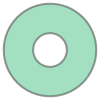

In [11]:
buffered - buffered_small

In [13]:
meta == originalmeta

False

In [29]:
def gen_buffer_list(buffer:float) -> list:
    import warnings
    lower_threshold = 3
    upper_threshold = 8
    upper_limit = 10
    if(buffer <= lower_threshold):
        raise ValueError(f"Buffer can not be less than {lower_threshold}. {buffer=}")
    elif(buffer > upper_threshold):
        raise ValueError(f"Buffer should not be grater or equal than {upper_threshold}. {buffer=}")

    full = buffer
    mid = buffer - 2
    inner = 2
    donut_full = (full, mid)
    donut_mid = (mid, inner)
    return [full, mid, inner, donut_full, donut_mid]

gen_buffer_list(8.1)

ValueError: Buffer should not be grater or equal than 8. buffer=8.1